In [159]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns

In [160]:
df = pd.read_csv('data/sensor09__0_0.csv').drop(columns=['sensorId'])

df.head()

,timestamp,co2,humidity,light,motion,temperature
0,2023-03-31T11:47:16Z,706.0,43.0,303.0,1.0,19.1
1,2023-03-31T12:02:23Z,713.0,42.0,371.0,0.0,19.2
2,2023-03-31T12:07:16Z,705.0,42.0,379.0,0.0,19.3
3,2023-03-31T12:22:23Z,724.0,42.0,339.0,0.0,19.4
4,2023-03-31T12:37:16Z,726.0,42.0,329.0,0.0,19.6


In [161]:
df.describe()

,co2,humidity,light,motion,temperature
count,252882.000000,252884.000000,252884.000000,252884.000000,252884.000000
mean,593.013702,42.426361,83.176081,0.212690,22.039324
std,301.605593,6.882490,157.522714,0.993209,2.935954
min,310.000000,24.000000,1.000000,0.000000,15.600000
25%,416.000000,37.000000,1.000000,0.000000,19.600000
50%,455.000000,42.000000,3.000000,0.000000,21.700000
75%,646.000000,47.000000,116.000000,0.000000,23.900000
max,2699.000000,75.000000,2295.000000,166.000000,32.300000


In [162]:
df.dtypes

timestamp       object
co2            float64
humidity       float64
light          float64
motion         float64
temperature    float64
dtype: object

In [163]:
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

df = df.set_index('timestamp')

df.dtypes

co2            float64
humidity       float64
light          float64
motion         float64
temperature    float64
dtype: object

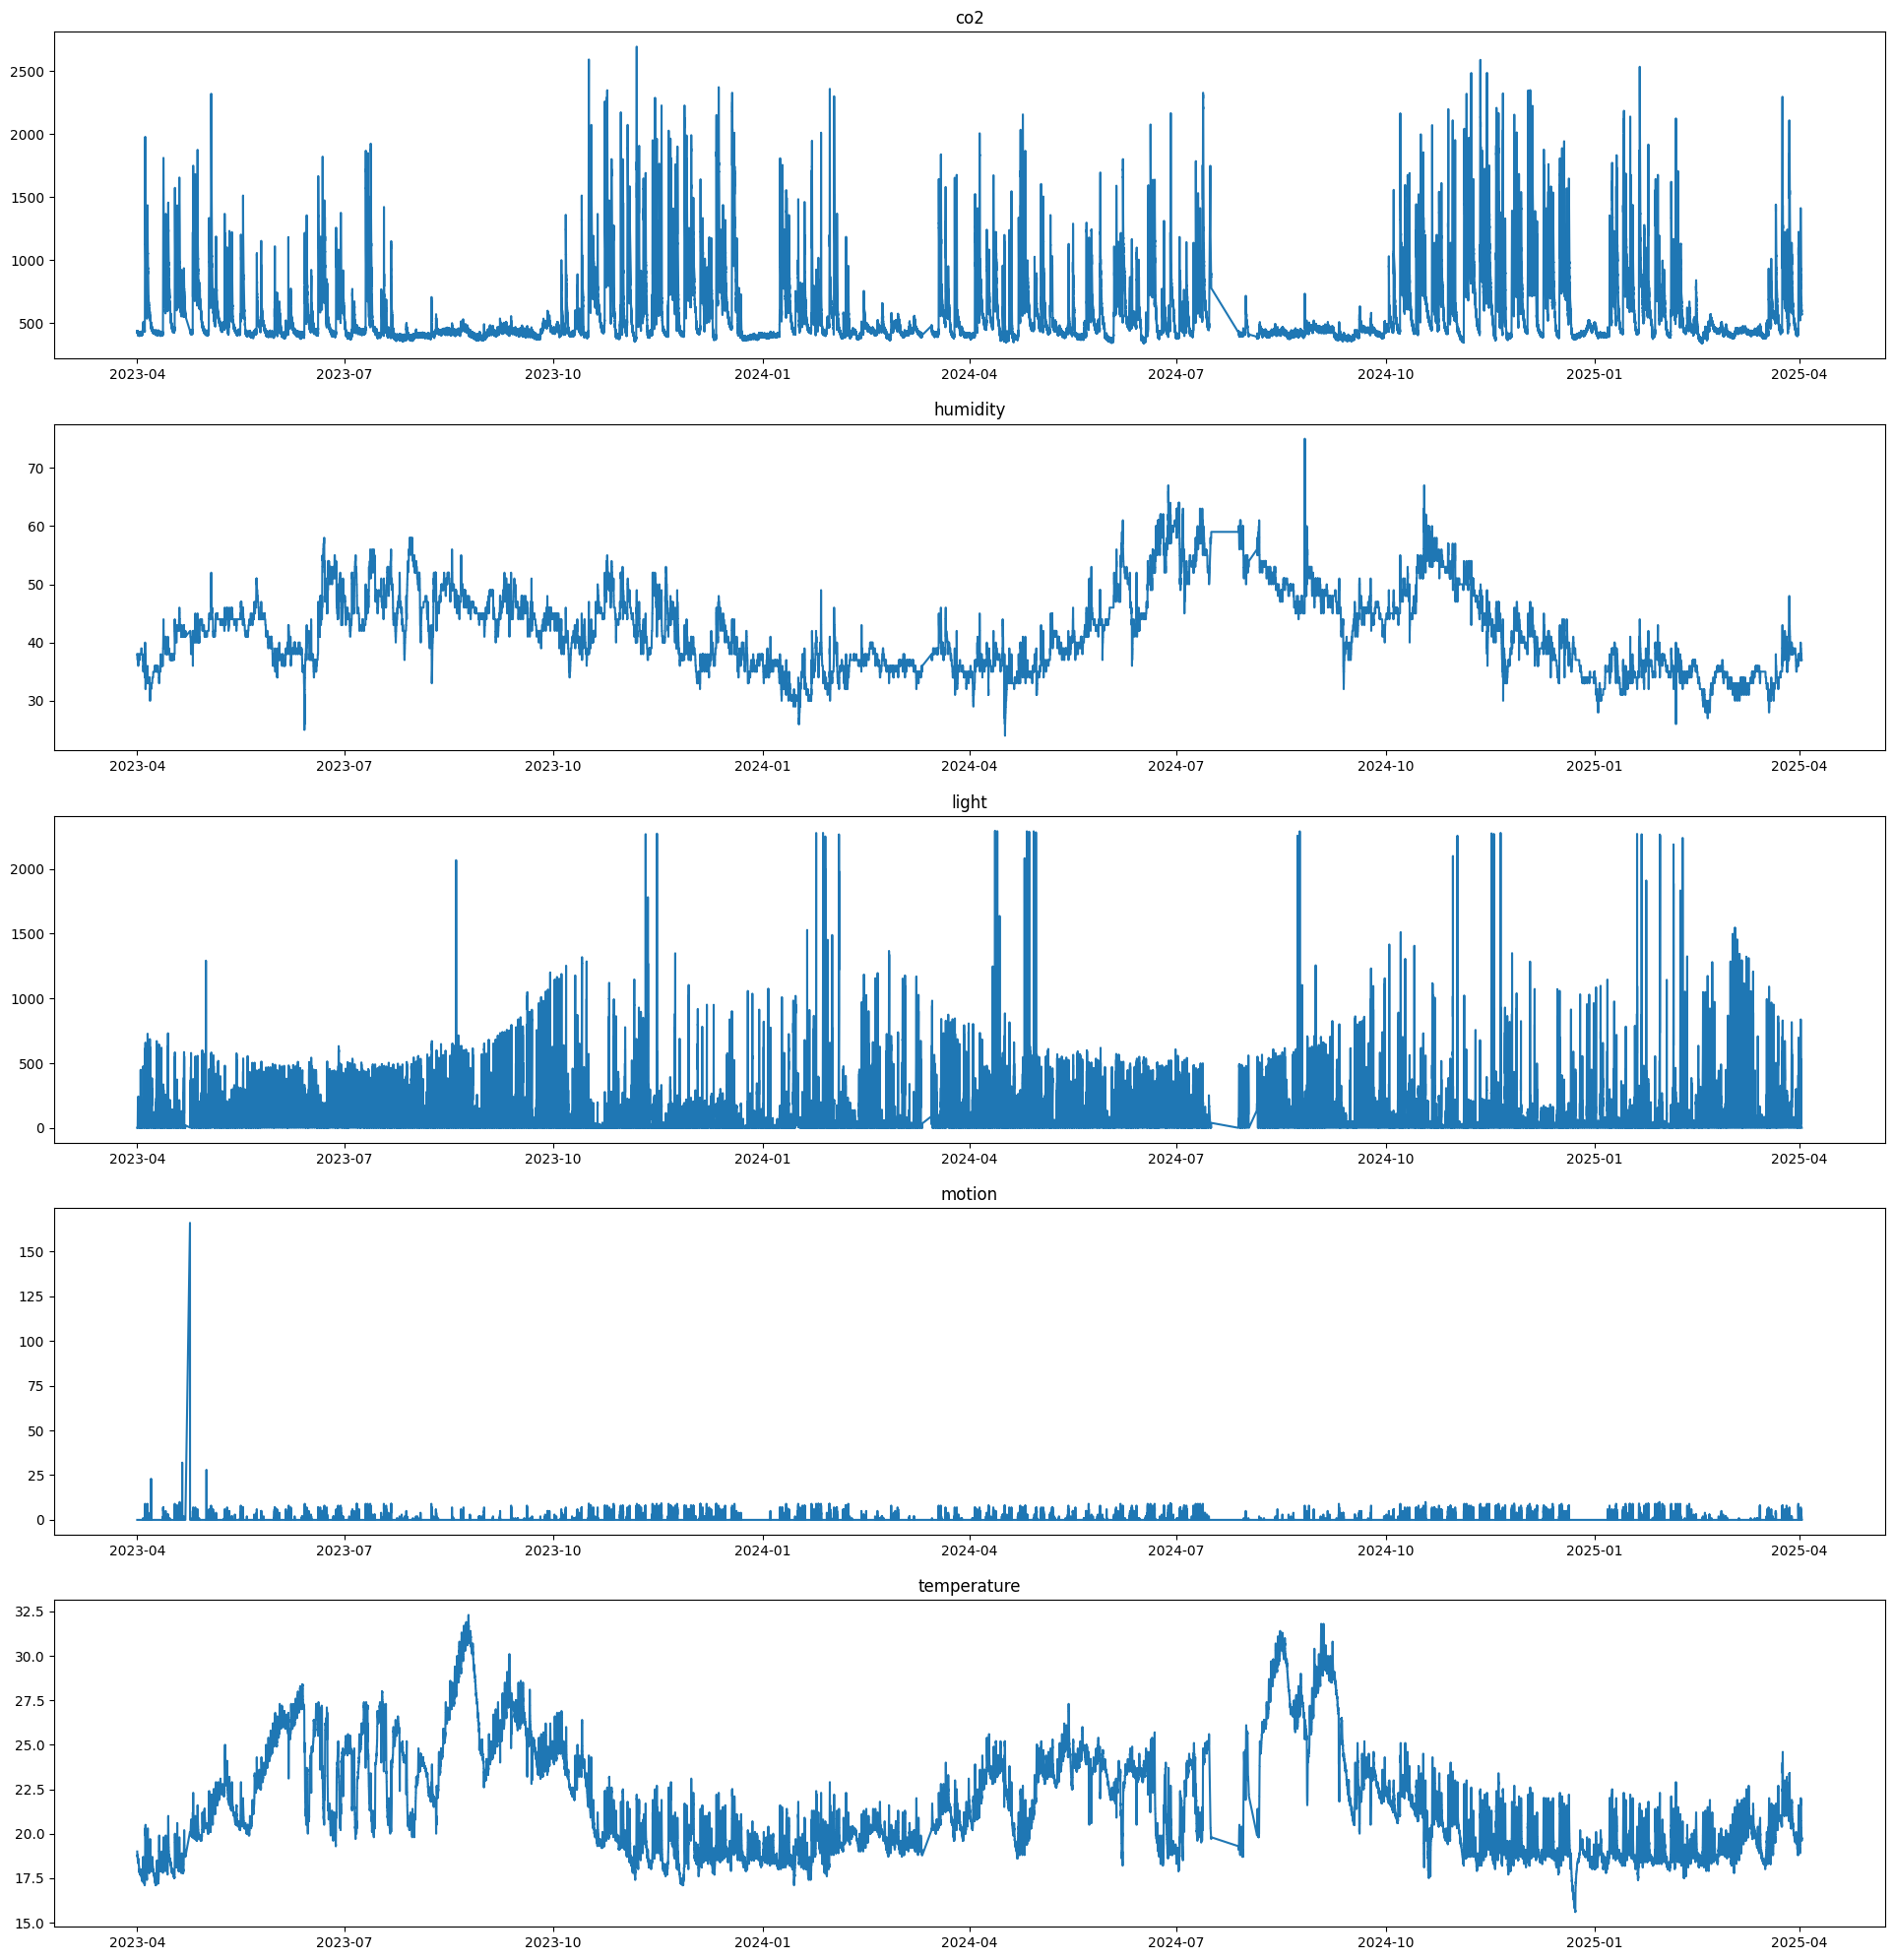

In [164]:
from matplotlib import use


df_year = df.loc['2023-04-01':'2025-04-01']

fig, ax = plt.subplots(5, 1, figsize=(24, 25))

for i, key in enumerate(df_year.keys().to_list()):
    ax[i].plot(df_year.index, df_year[key])
    ax[i].set_title(key)

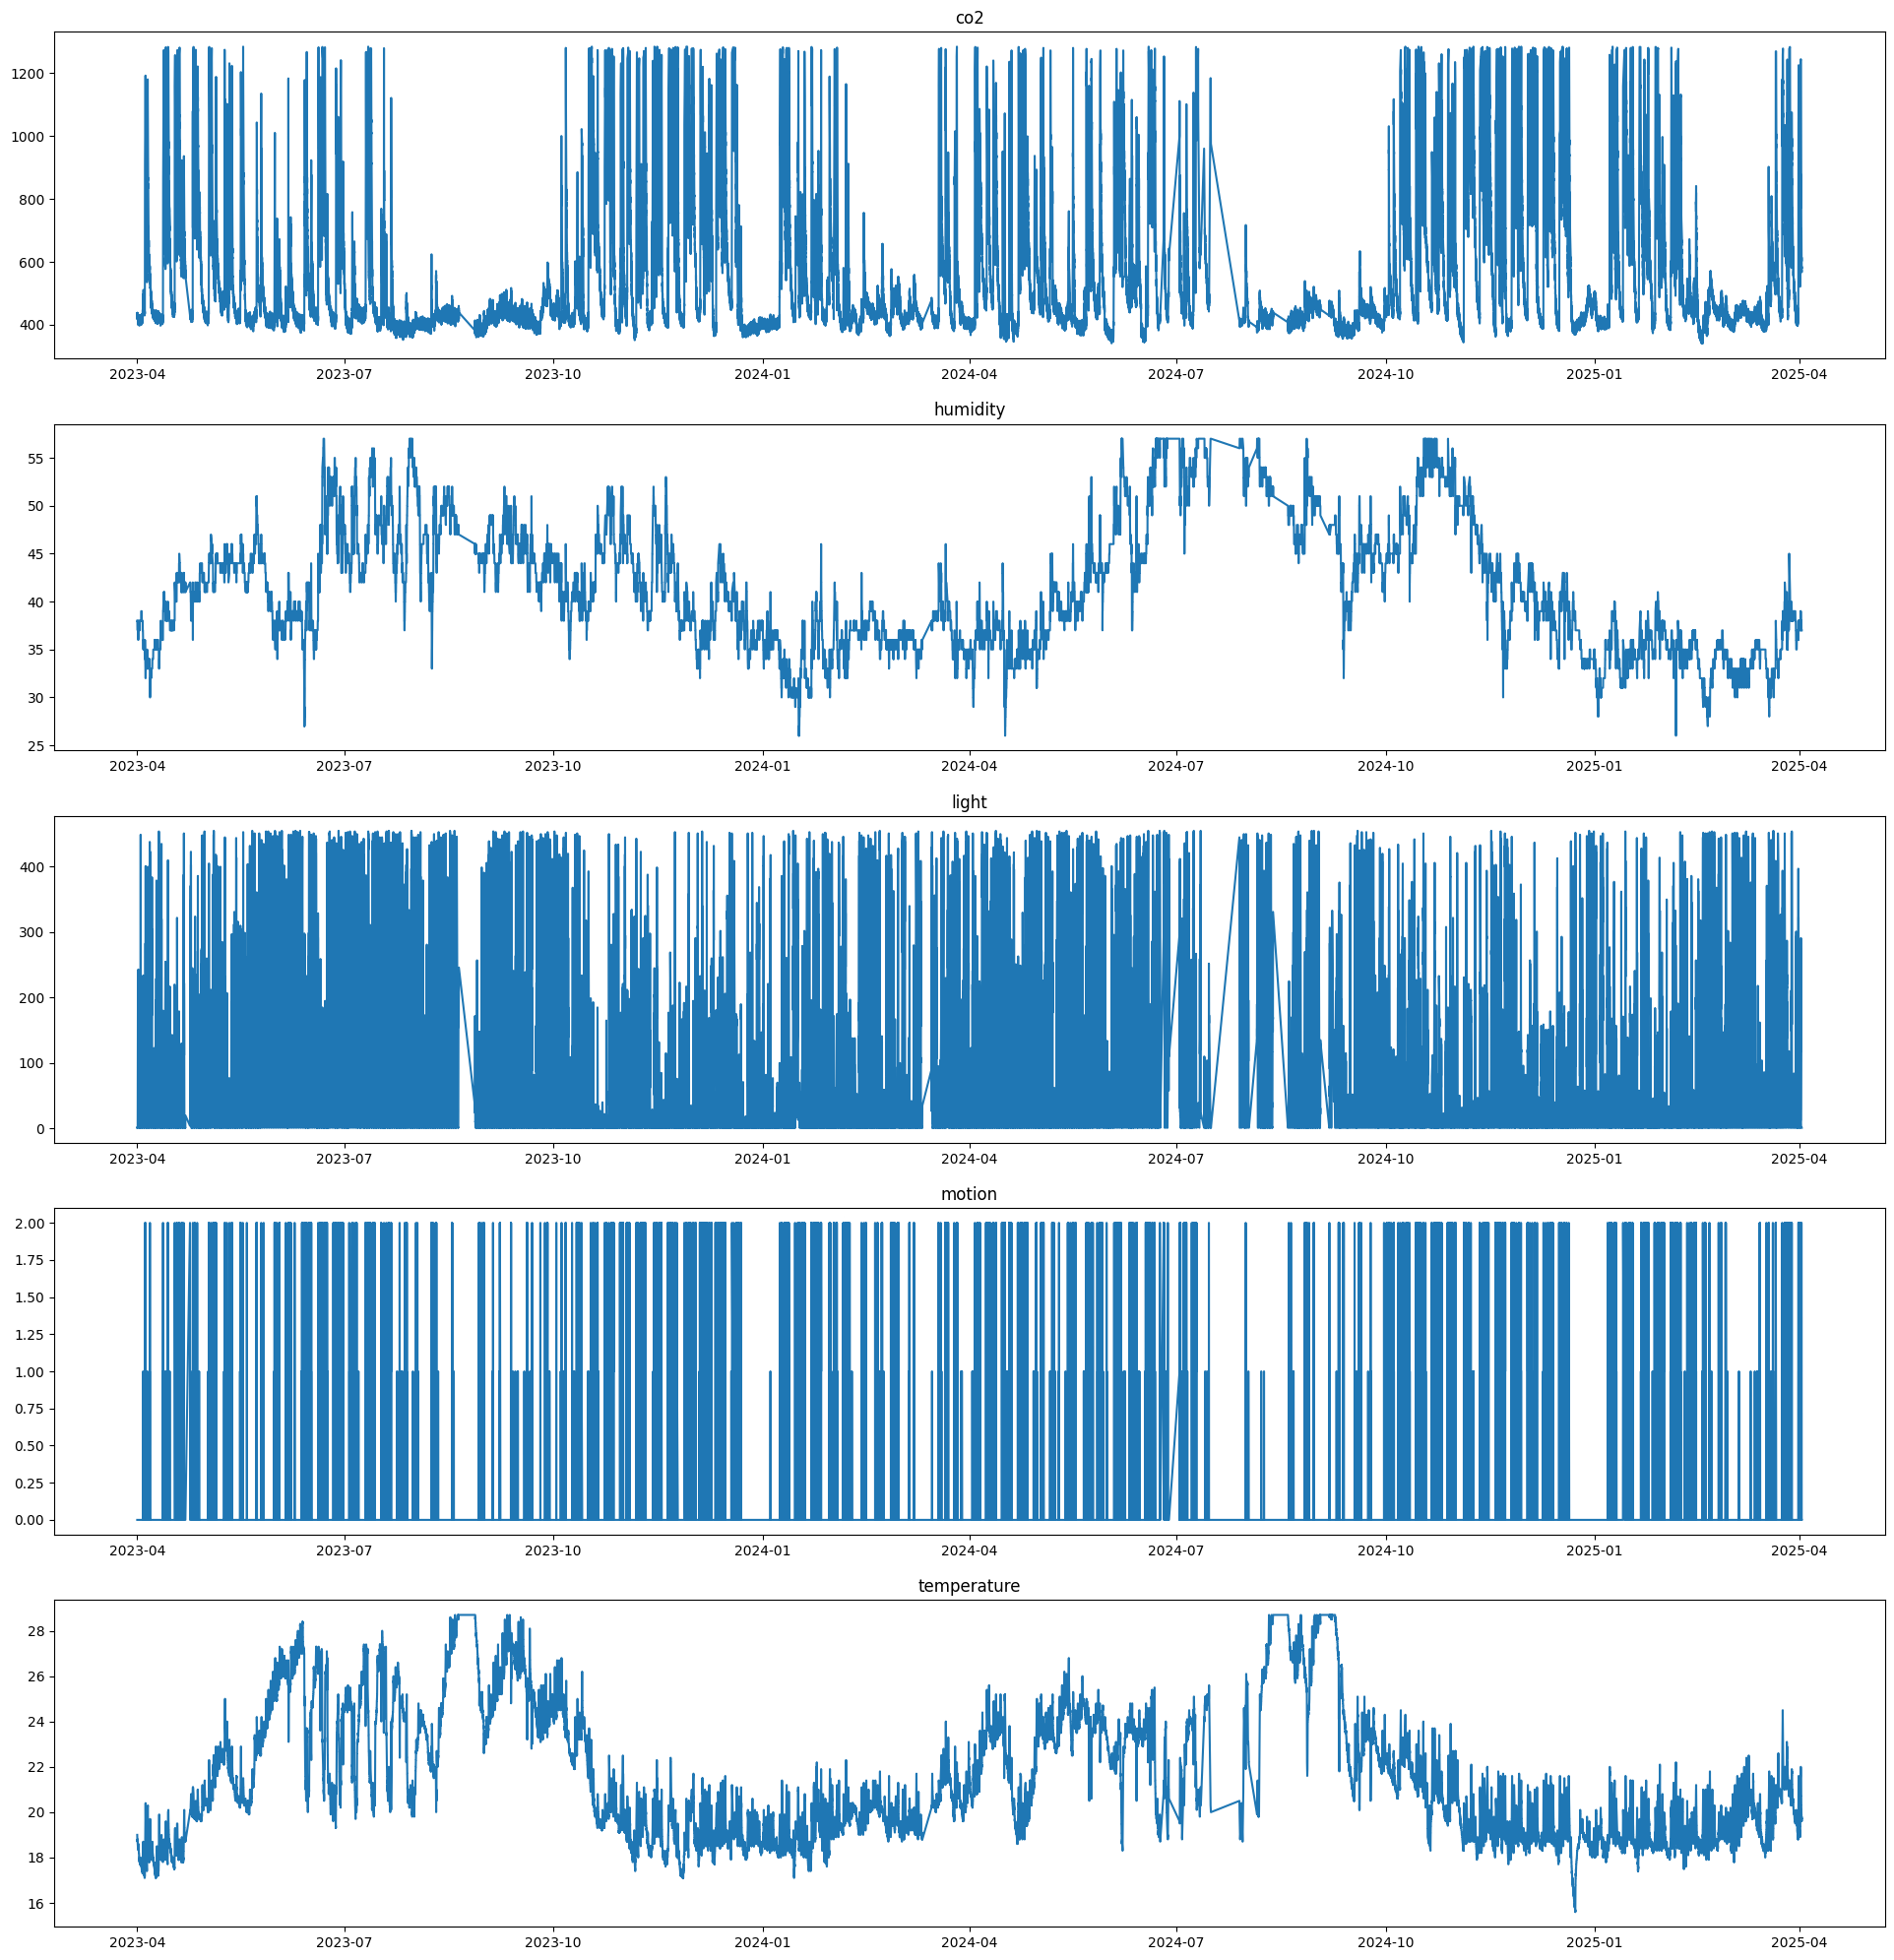

In [165]:
# Remove outliers using Z-score
# Remove all rows with std > 3 on numeric columns
numeric_cols = df_year.select_dtypes(include=[np.number]).columns
z_scores = (df_year[numeric_cols] - df_year[numeric_cols].mean()) / df_year[numeric_cols].std()
df_year = df_year[(np.abs(z_scores) < 2.33).all(axis=1)] # 2.3 equals approx 99% confidence interval

fig, ax = plt.subplots(5, 1, figsize=(24, 25))

for i, key in enumerate(df_year.keys().to_list()):
        ax[i].plot(df_year.index, df_year[key])
        ax[i].set_title(key)

<Axes: >

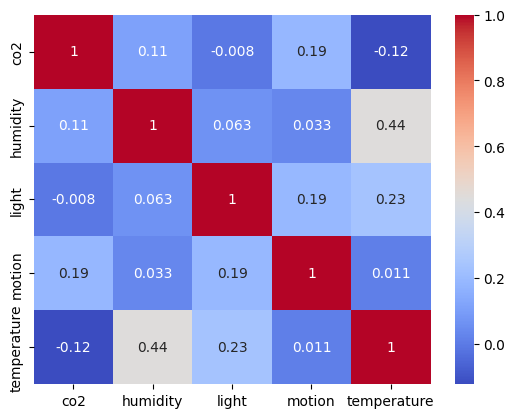

In [166]:
sns.heatmap(df_year.corr(), annot=True, cmap='coolwarm')


array([[<Axes: title={'center': 'co2'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'light'}>,
        <Axes: title={'center': 'motion'}>],
       [<Axes: title={'center': 'temperature'}>, <Axes: >]], dtype=object)

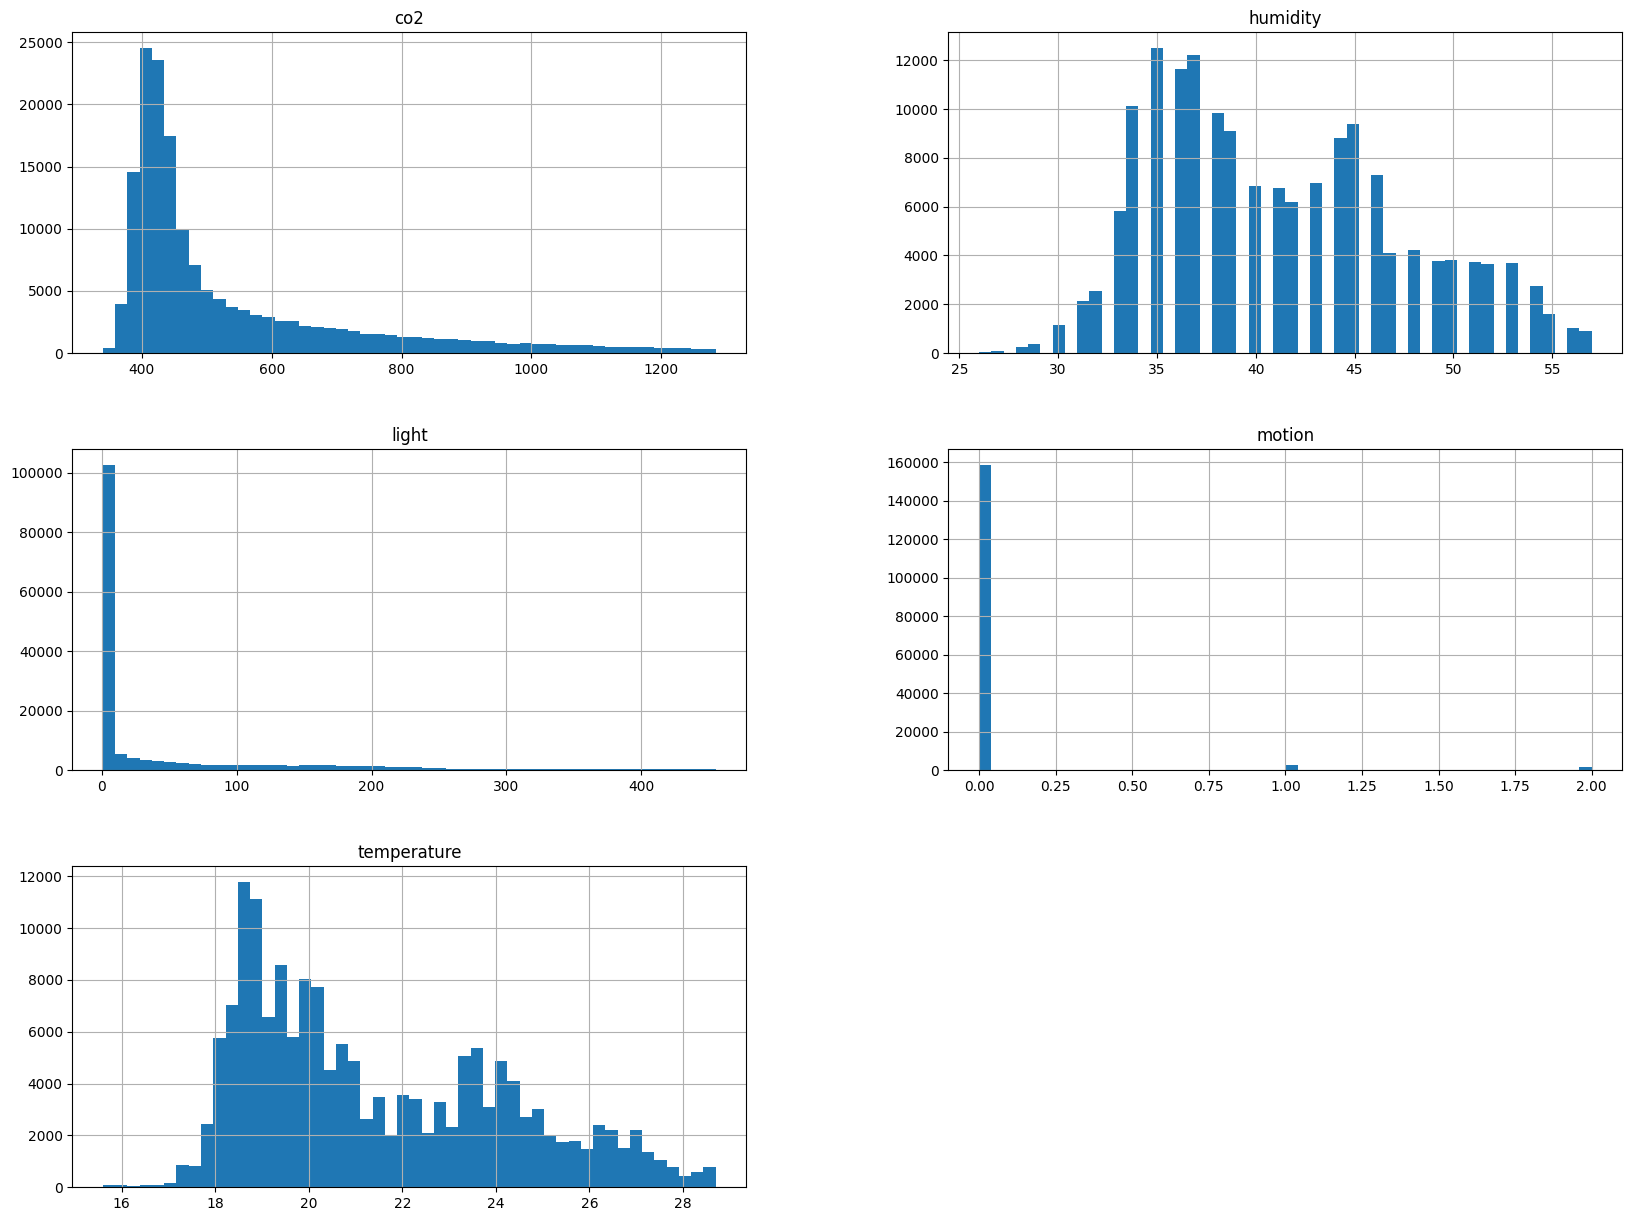

In [167]:
df_year.hist(bins=50, figsize=(20, 15))

Text(0.5, 1.0, 'Temperature over Time')

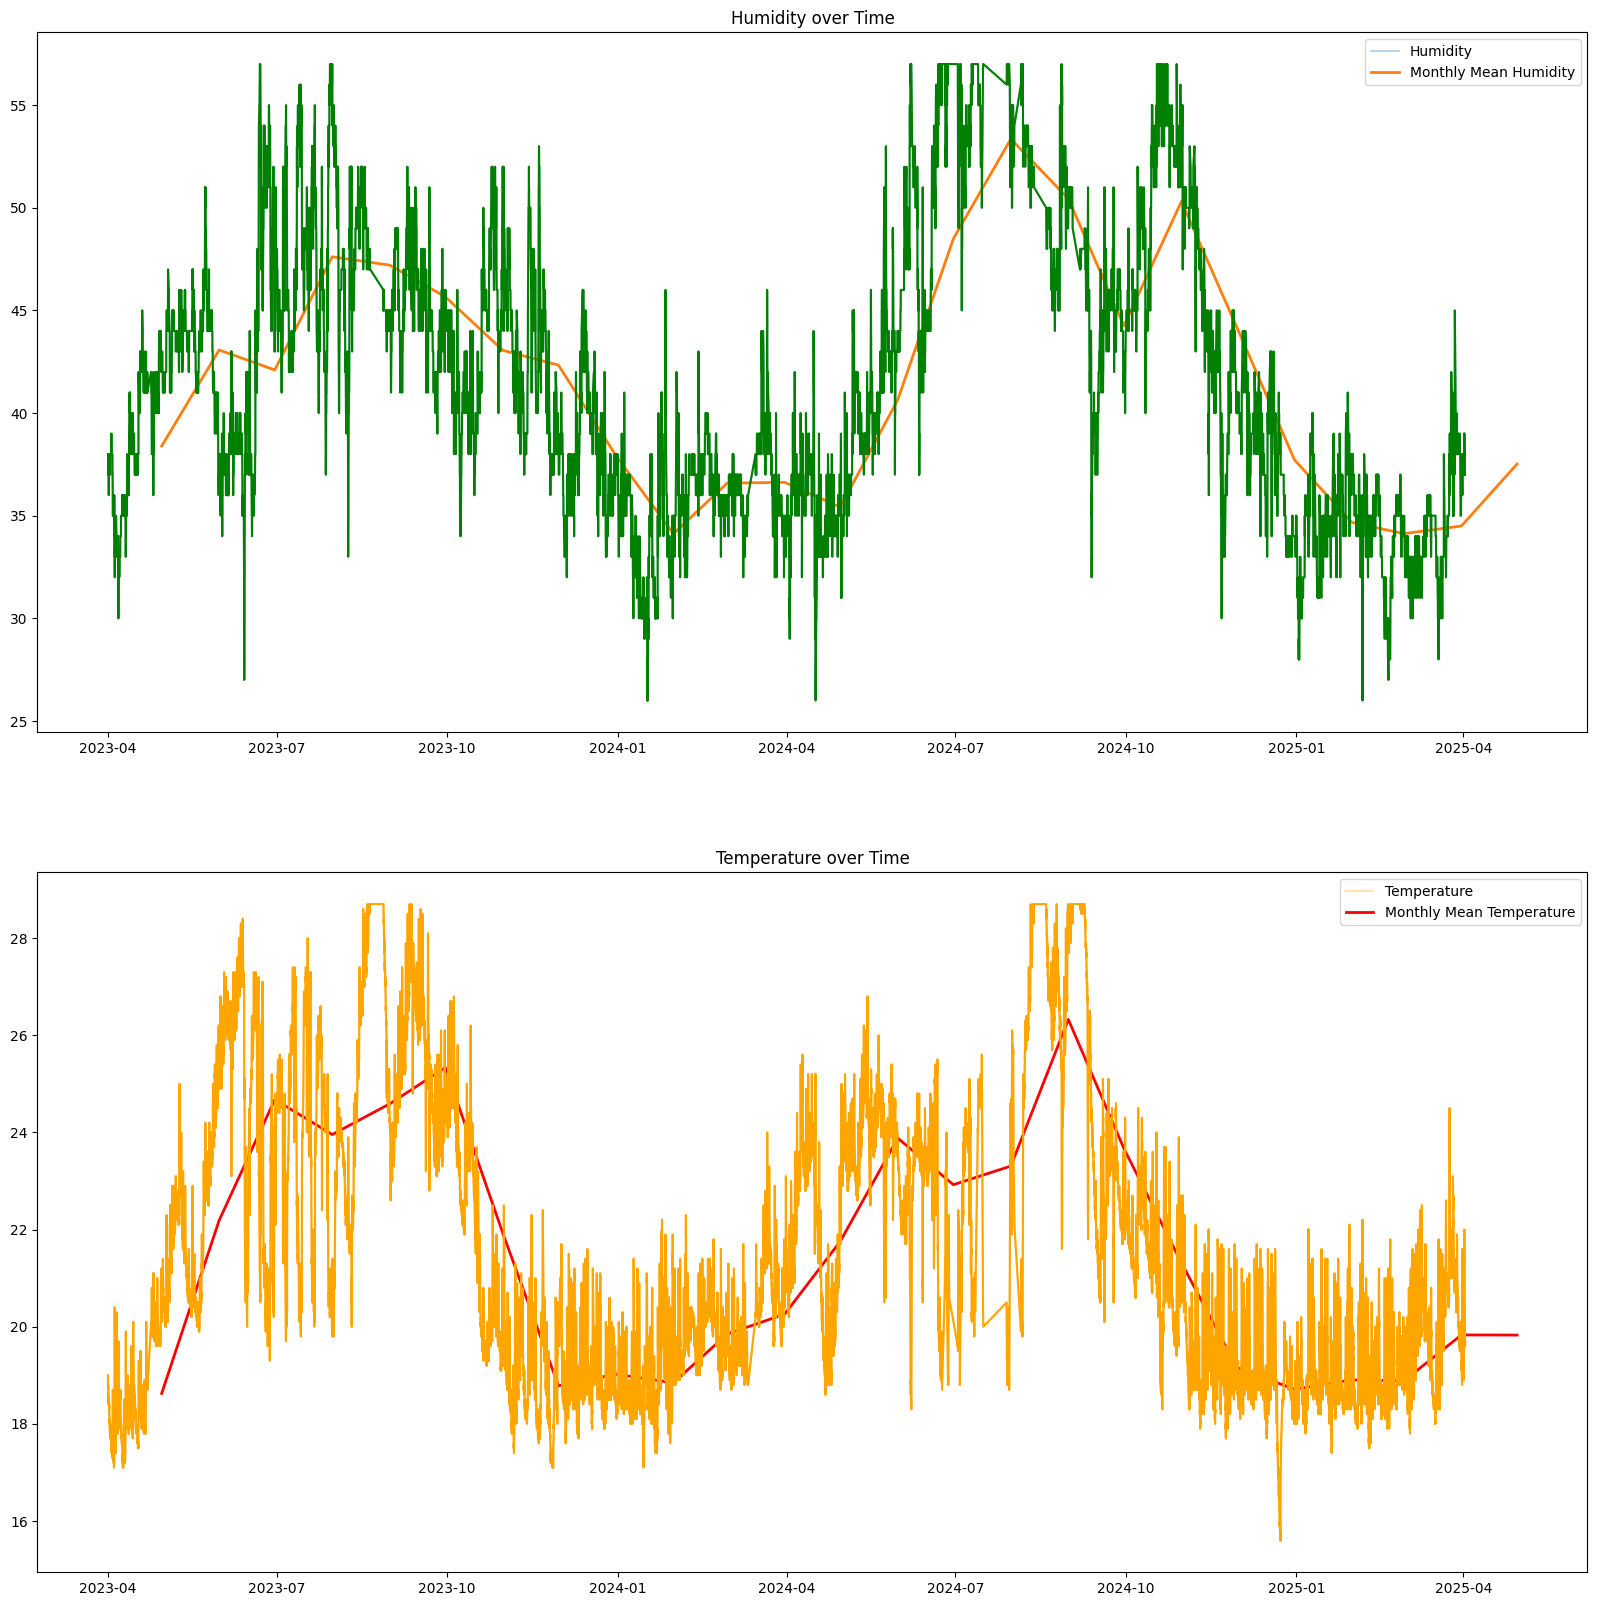

In [168]:
from turtle import color


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

df_group = df_year.resample('ME').mean()

ax1.plot(df_year.index, df_year['humidity'], label='Humidity', alpha=0.3)
ax1.plot(df_group.index, df_group['humidity'], label='Monthly Mean Humidity', linewidth=2)
ax1.legend()

ax2.plot(df_year.index, df_year['temperature'], label='Temperature', color='orange', alpha=0.3)
ax2.plot(df_group.index, df_group['temperature'], label='Monthly Mean Temperature', color='red', linewidth=2)
ax2.legend()

ax1.plot(df_year.index, df_year['humidity'], label='Humidity', color='green')
ax1.set_title('Humidity over Time')
ax2.plot(df_year.index, df_year['temperature'], label='Temperature', color='orange')
ax2.set_title('Temperature over Time')

Text(0.5, 1.0, 'Differenced Temperature over Time')

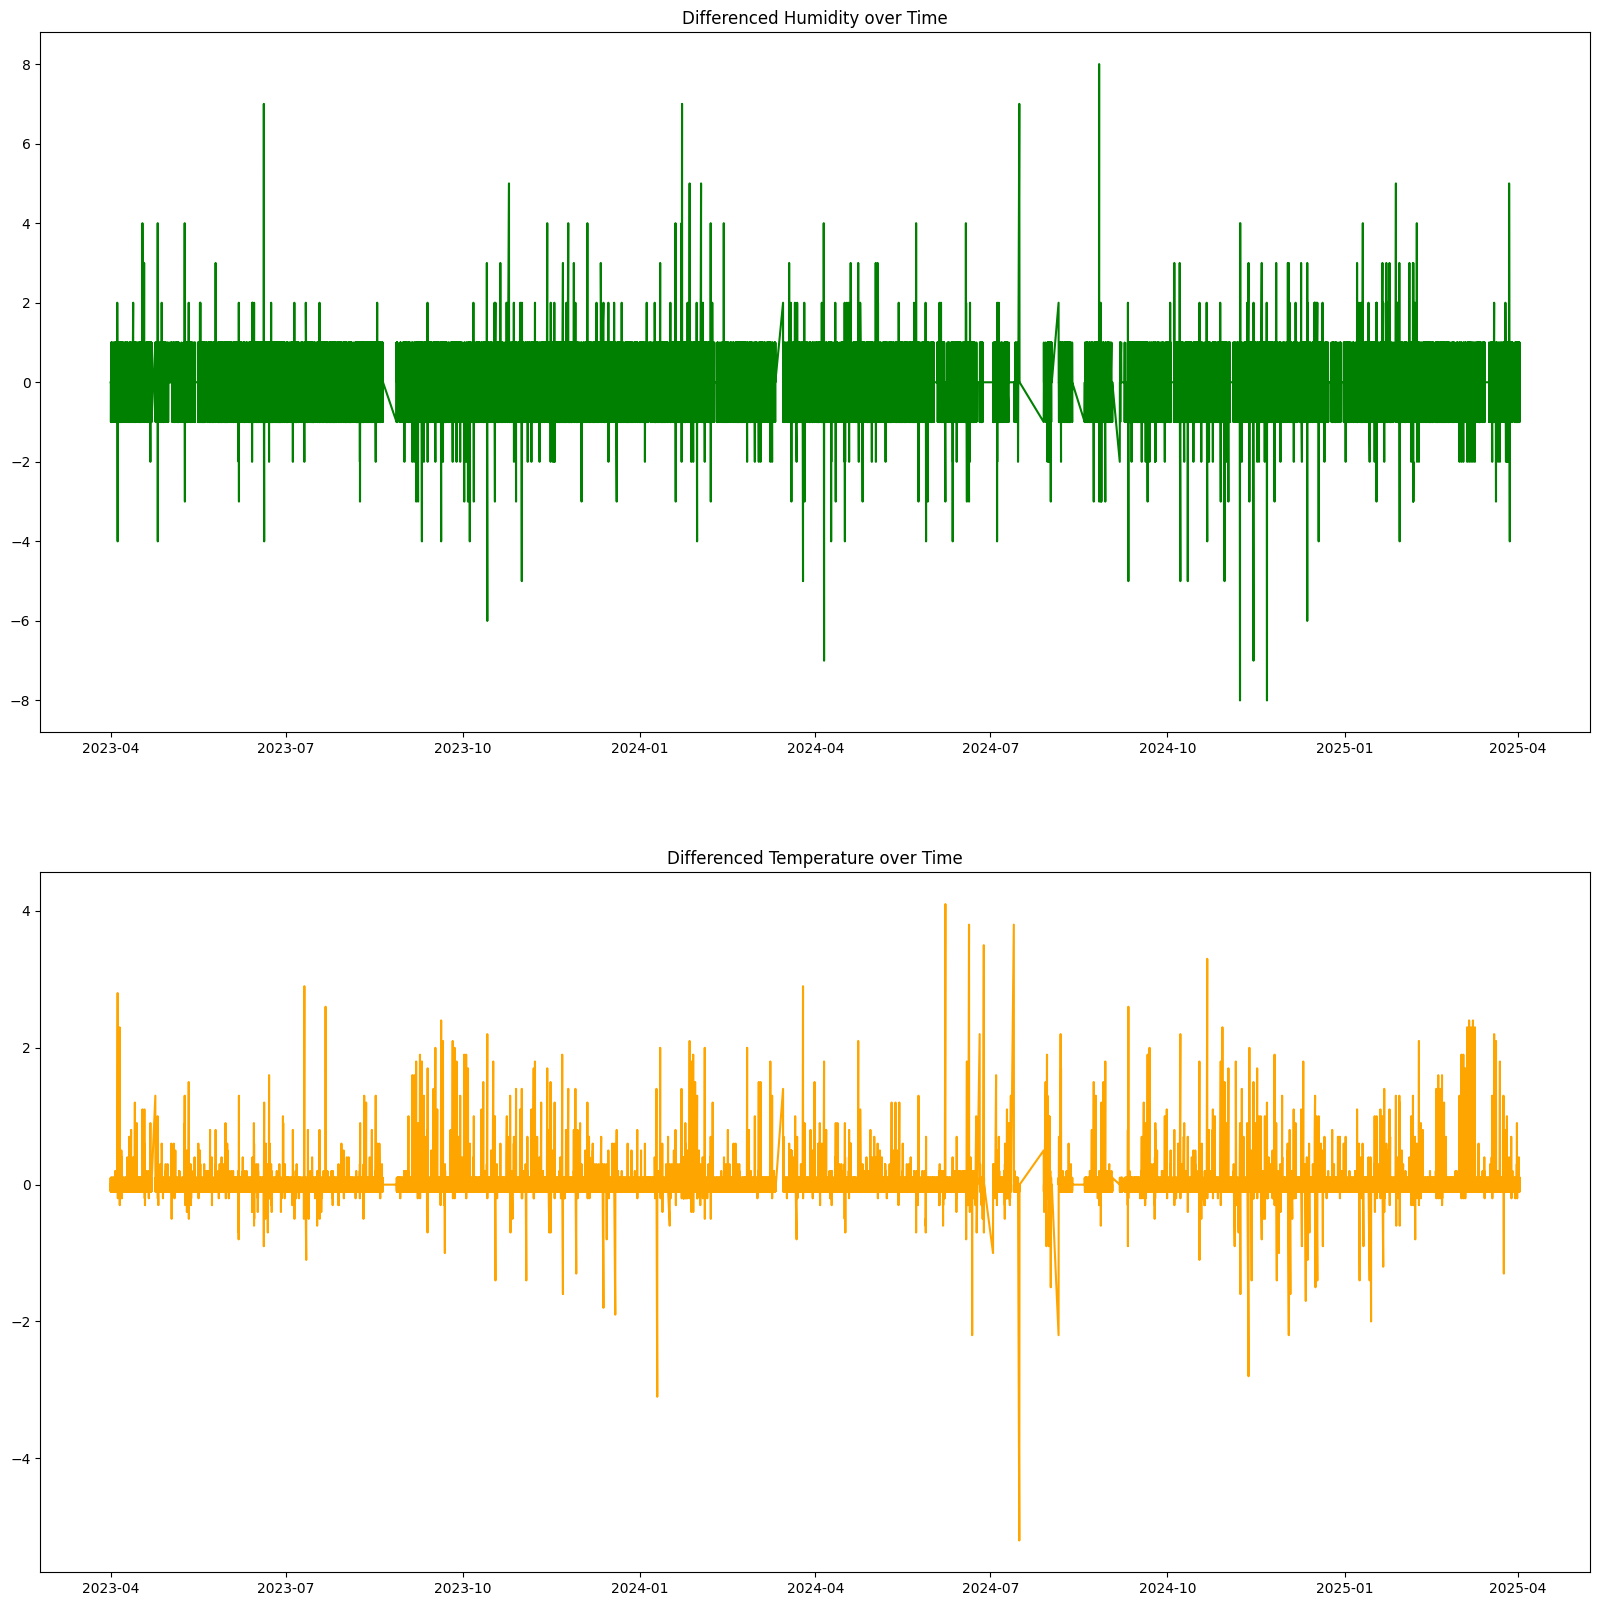

In [169]:
# Create differenced DataFrame
df_diff = df_year.diff().fillna(0)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

ax1.plot(df_diff.index, df_diff['humidity'], label='Humidity', color='green')
ax1.set_title('Differenced Humidity over Time')
ax2.plot(df_diff.index, df_diff['temperature'], label='Temperature', color='orange')
ax2.set_title('Differenced Temperature over Time')


Text(0.5, 1.0, 'CO2 over Time')

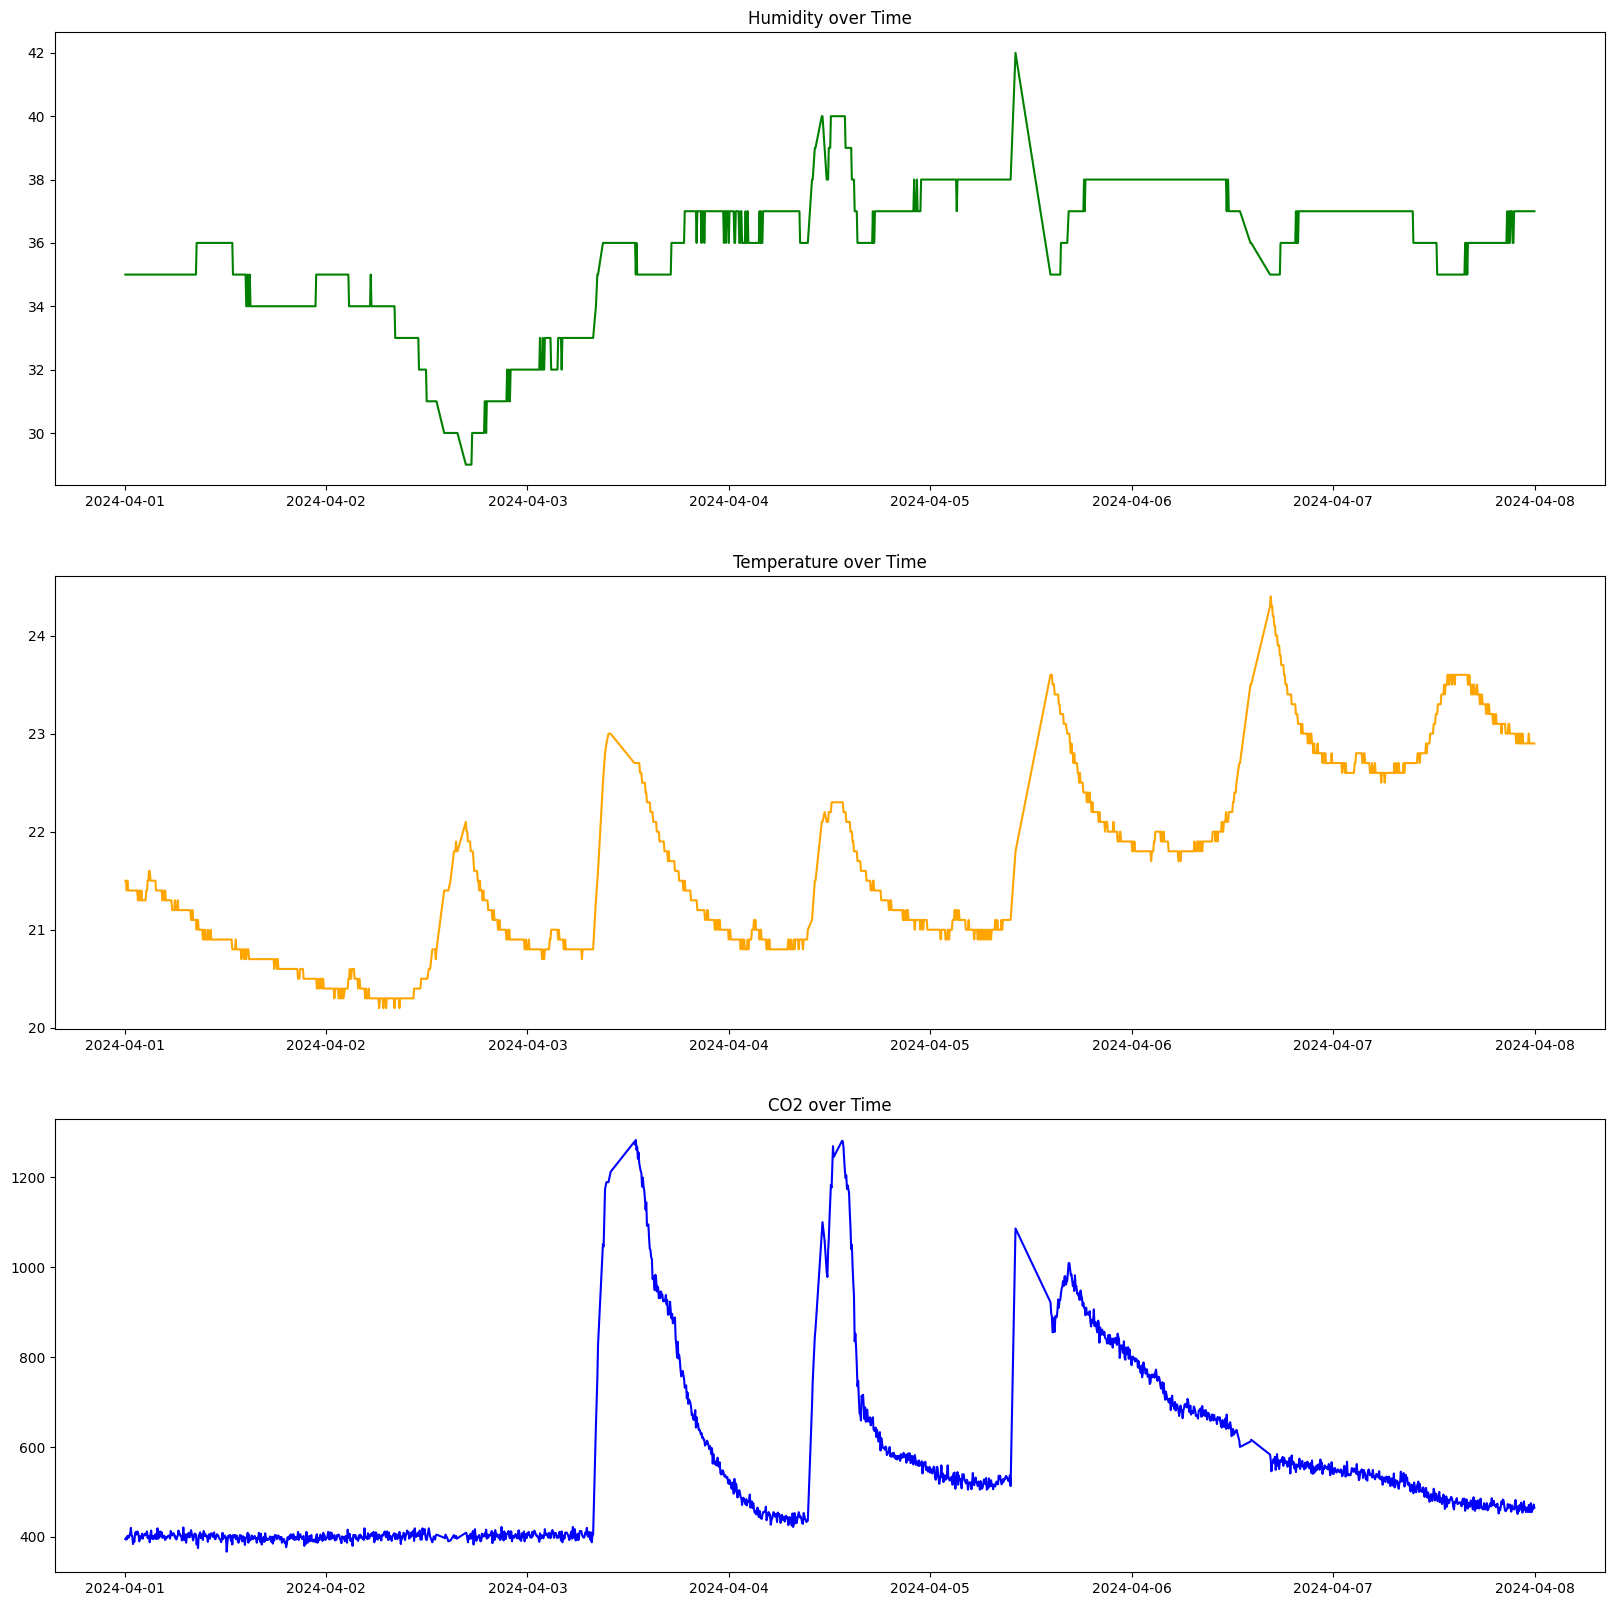

In [170]:
df_week = df_year['2024-04-01':'2024-04-07'].copy() # Monday

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20))

ax1.plot(df_week.index, df_week['humidity'], label='Humidity', color='green')
ax1.set_title('Humidity over Time')
ax2.plot(df_week.index, df_week['temperature'], label='Temperature', color='orange')
ax2.set_title('Temperature over Time')
ax3.plot(df_week.index, df_week['co2'], label='CO2', color='blue')
ax3.set_title('CO2 over Time')

Text(0.5, 1.0, 'Trend Reduced CO2 over Time')

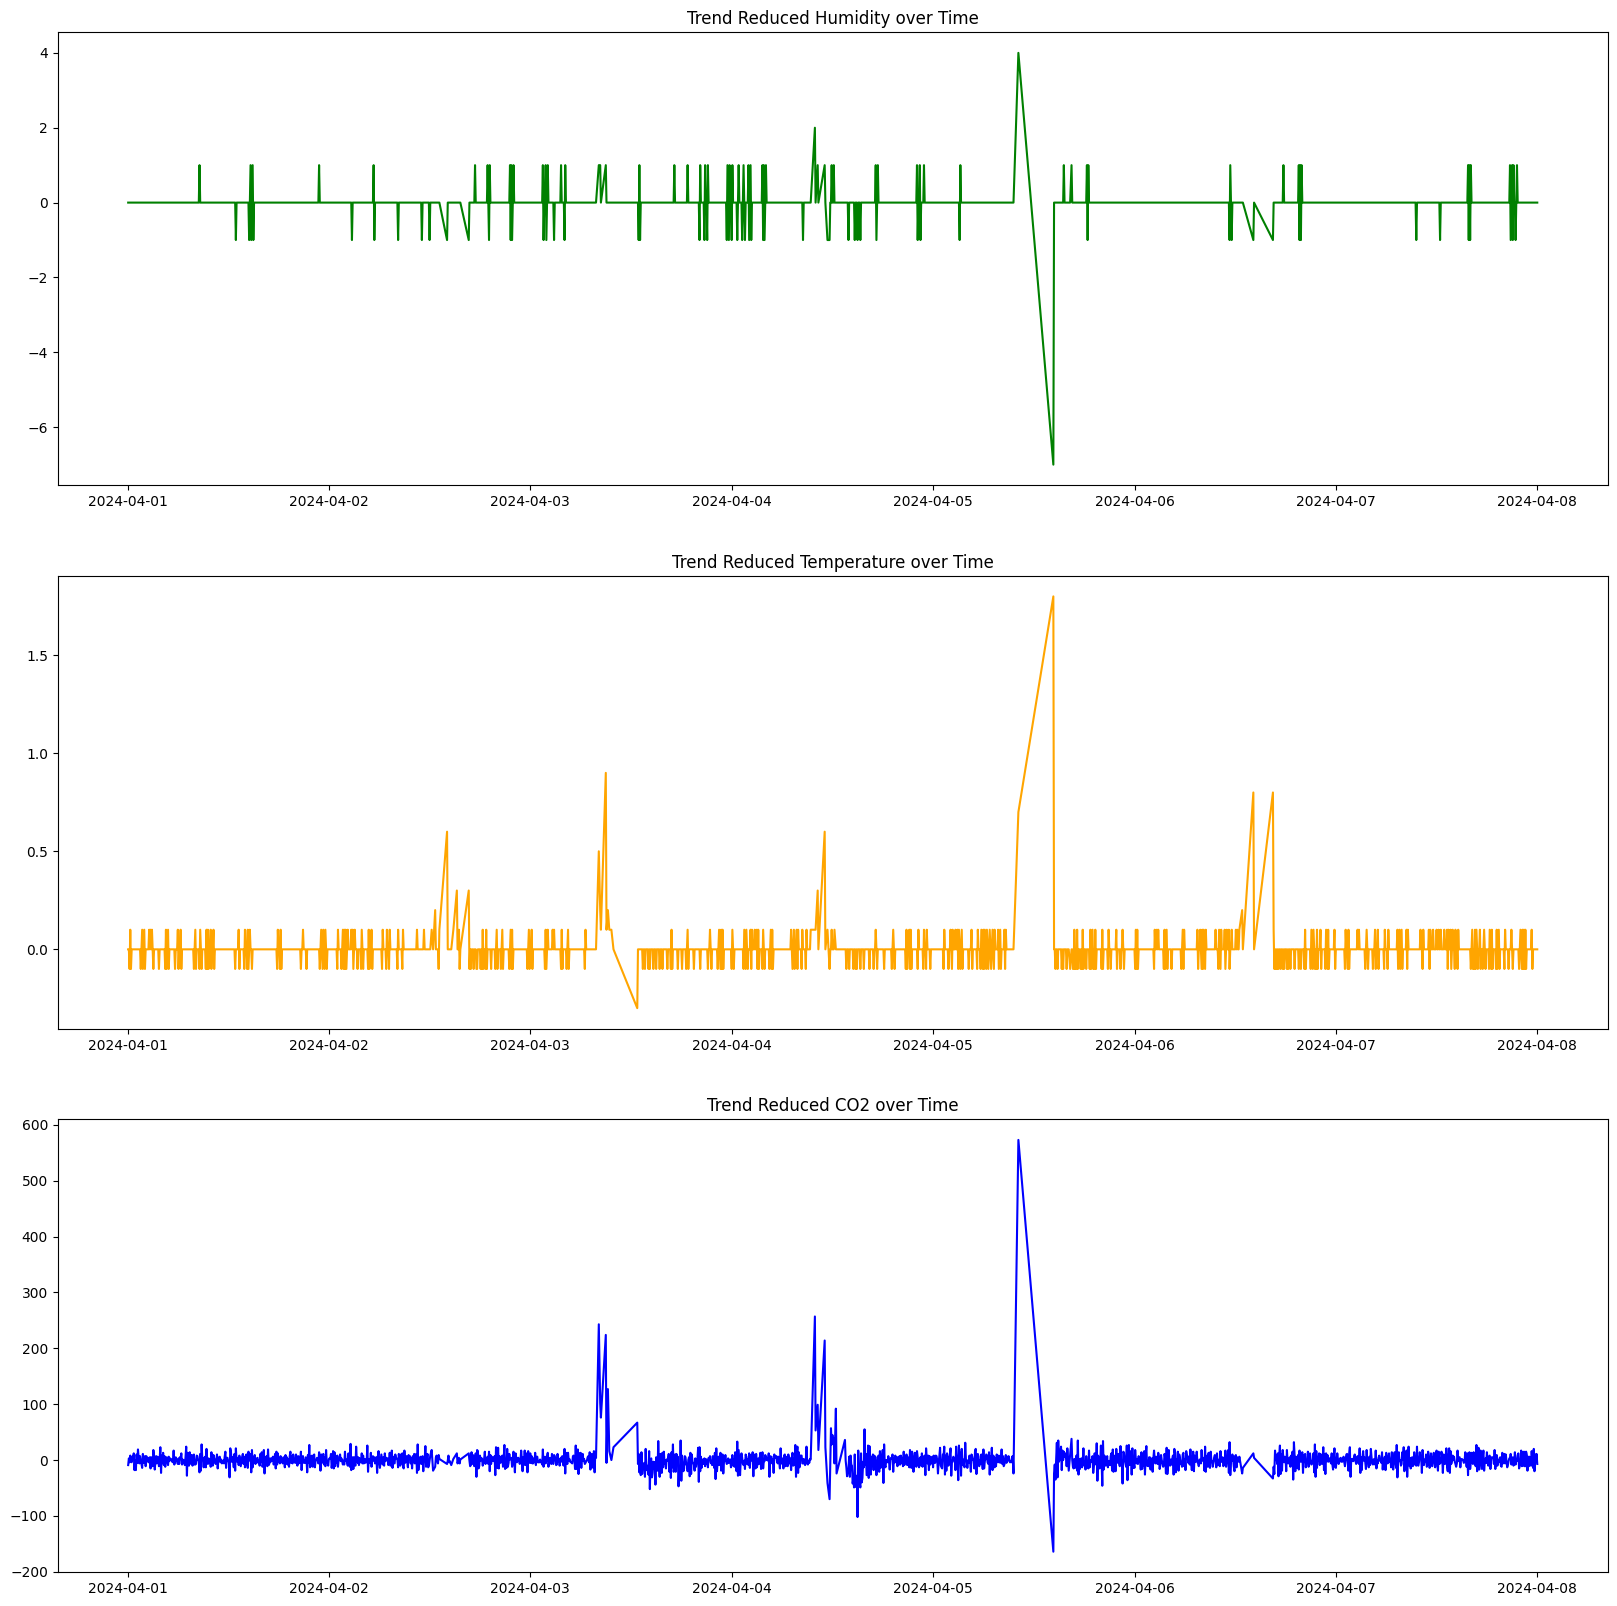

In [171]:
df_diff_week = df_diff['2024-04-01':'2024-04-07'].copy() # Monday

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20))

ax1.plot(df_diff_week.index, df_diff_week['humidity'], label='Humidity', color='green')
ax1.set_title('Trend Reduced Humidity over Time')
ax2.plot(df_diff_week.index, df_diff_week['temperature'], label='Temperature', color='orange')
ax2.set_title('Trend Reduced Temperature over Time')
ax3.plot(df_diff_week.index, df_diff_week['co2'], label='CO2', color='blue')
ax3.set_title('Trend Reduced CO2 over Time')

Text(0.5, 1.0, 'CO2 and Motion on 2024-04-01:2024-04-07')

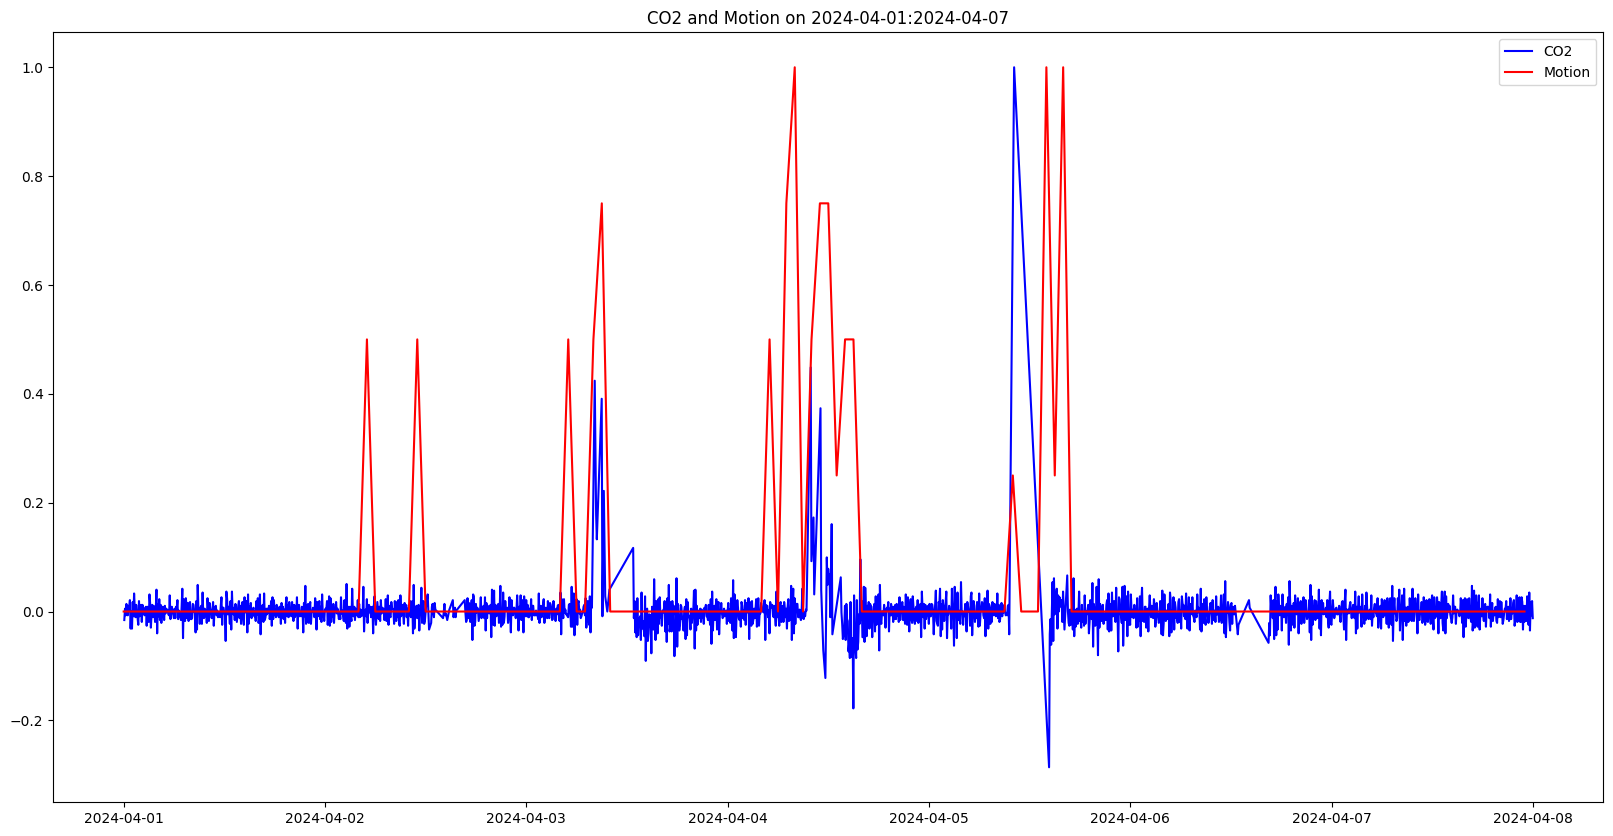

In [172]:
df_diff_week['motion'] = df_diff_week['motion'].astype(bool)

df_motion = df_diff_week['motion'].resample('h').sum()
df_motion = df_motion / df_motion.max() # Normalize motion data

df_diff_week['co2'] = df_diff_week['co2'] / df_diff_week['co2'].max() # Normalize CO2 data

plt.figure(figsize=(20, 10))
plt.plot(df_diff_week.index, df_diff_week['co2'], label='CO2', color='blue')
plt.plot(df_motion.index, df_motion, label='Motion', color='red')
plt.legend()
plt.title('CO2 and Motion on 2024-04-01:2024-04-07')
